In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import time
from scipy.signal import butter, lfilter
import digital_filter as dfilter

# DigitalFilter(FIRフィルタ) まとめ

## <b>代表的なDigitalFilter</b>  
### 1. FIRフィルタ(FIR:有限インパルス応答(Finite Impulse Response))  
$$
            y[n]=\sum_{k=0}^{N}h[k]x[n-k] \quad
$$
N=フィルタ次数  
時刻nのとき、y[n]はシステムの出力、x[n]はシステムの入力、h[k]はデジタルフィルタのインパルス応答  
出力は入力とインパルス応答との畳み込み和でのみ計算される。[つまりフィルタ次数分のインパルス応答と信号の畳み込み]    
インパルス応答は、FIRフィルタ次数 or タップ係数と呼ばれる  
  
### 2. IIRフィルタ(IIR:無限インパルス応答(Infinite Impulse Response))  
$$
            y[n]=\sum_{k=0}^{∞}h[k]x[n-k] \quad
$$
IIRフィルタはインパルス応答の無限和の計算が必要であるが現実には実行できないので、  
ある程度有限の応答としてk=0の項とそれ以外に分けて、前時刻の計算結果を含めて以下のように変換  
$$
            y[n]=\sum_{k=0}^{P}h_{a}[k]x[n-k] - \sum_{i=0}^{Q}h_{b}[i]x[n-i]\quad
$$
FIRフィルタでは極(分母多項式=0の根)が原点であるが、IIRフィルタでは極が定まらず不安定になる場合がある為、使い勝手が難しい  
基本FIRしか使わない気がするので、FIRについて以下の通りまとめる

## 参考URL
### DigitalFitler：
フィルタ特性と特性 http://www.nfcorp.co.jp/techinfo/keisoku/module/f_chara.html  
DigitalFilter理論説明 https://tmytokai.github.io/open-ed/activity/d-filter/text02/page03.html  
FIRフィルタ実装 https://watlab-blog.com/2019/04/30/scipy-lowpass/  
Butterworse Filter理論 http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/butterworth.html  
Butterworse Filter数式 http://arduinopid.web.fc2.com/K22.html  
Chebyshev Filter1 https://ufcpp.net/study/sp/digital_filter/chebyshev/  
Chebyshev Filter2 http://www.edic-systems.co.jp/article/13956068.html

### FFT関連：
FFT scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html  
窓関数の役割 http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/win.html  
窓関数の種類 https://ja.wikipedia.org/wiki/%E7%AA%93%E9%96%A2%E6%95%B0#%E3%83%8F%E3%83%B3%E7%AA%93  
窓関数実装 https://watlab-blog.com/2019/04/17/scipy-window/

### 代表的なFIRフィルタ  
#### <span style="color: red; ">移動平均フィルタ
<span style="color: red; ">
$$
            y[n]=\sum_{k=0}^{N}\frac{1}{L}x[n-k] \quad
$$
　過去L時間分の入力信号値の単純平均を出力するフィルタ</span> 
  
#### <span style="color: blue; ">ButterWorseフィルタ</span>
<span style="color: blue; ">  
時間領域での入出力関係式が出てこなかったので、伝達関数↓
$$
            G^{2}(ω)=\frac{G_{0}^{2}}{1+(\frac{ω_{c}}{ω})^{2n}} 
$$
$$
            ω_{c}:カットオフ周波数
$$
　通過帯域でのリップル(揺らぎ)が無く、減衰が比較的緩やかな特性  
  通過帯域は全て通すフィルタであり、広く使われる</span>
  
#### <span style="color: green; ">第一種Chebyshevフィルタ</span>
<span style="color: green; ">
  時間領域での入出力関係式が出てこなかったので、伝達関数(n次のローパスフィルタ)↓
$$
            G_{n}(ω)=\frac{1}{\sqrt{1+e^{2}T_{n}^{2}(\frac{ω}{ω_{0}})}}
$$
$$
            e:リップル係数
$$
　通過帯域でのリップルが存在するが、Butterworseと比較して減衰頻度が大きくなる  
  減衰頻度を大きく取りたいときに有効(リップルの許容も必要)</span>
  
#### <span style="color: darkgreen; ">第二種Chebyshevフィルタ</span>
<span style="color: darkgreen; ">
  時間領域での入出力関係式が出てこなかったので、伝達関数(n次のローパスフィルタ)↓
$$
            G_{n}(ω)=\frac{1}{\sqrt{1+\frac{1}{e^{2}T_{n}^{2}(\frac{ω_{0}}{ω})}}}
$$
$$
            e:リップル係数
$$
　通過帯域と減衰域共にリップルを持たせることで、遷移行を最小にできるように考えられた特性  
  第一種Chebyshevフィルタよりも減衰頻度を大きく取りたいときに有効(リップルの許容も必要)</span>
  
#### <span style="color: orange; ">Besselフィルタ</span>
<span style="color: orange; ">
  時間領域での入出力関係式が出てこなかったので、伝達関数↓
$$
            H(s)=\frac{θ_{n}(0)}{θ_{n}(s/ω_{0})}
$$
$$
H(jω)=G(ω)
$$
　立ち上がり(過渡応答)特性を最適(綺麗に整える)にする場合に使用する</span>
  

# Sample信号

In [2]:
#サンプル波
dt = 0.005 #1stepの時間[sec]
fs = 1/dt
times  =  np.arange(0,10,dt)
N = times.shape[0]

f  = 5  #サイン波の周波数[Hz]
sigma  = 0.5 #ノイズの分散

np.random.seed(1)
# サイン波
x_s =np.sin(2 * np.pi * times * f) 
x = x_s  +  sigma * np.random.randn(N)

x_np = np.array(x)

# 矩形波
y_s =  np.zeros(times.shape[0])
y_s[:times.shape[0]//2] = 1
y = y_s  +  sigma * np.random.randn(N)

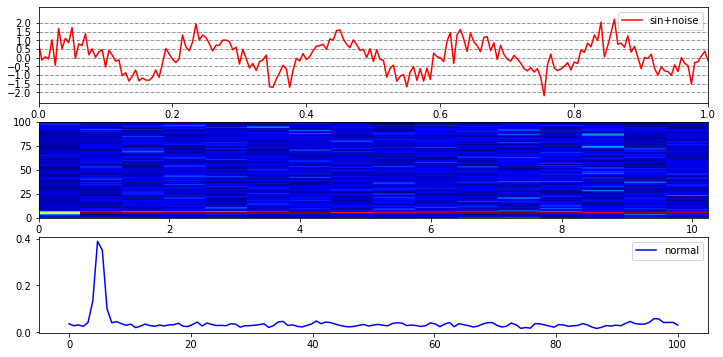

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x, c="red", label=("sin+noise"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(x_np, dt)

plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 0
end = 2
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("normal"))
plt.legend()

# プロット表示(設定の反映)
plt.show()

# 以下 各種まとめ(自身の信号にフィルタを掛けたい場合は、"x="に代入して対応)

### <span style="color: red; ">移動平均フィルタ</span>

In [104]:
move_num = 5 #移動平均個数設定
dt = 0.005 #SamplingTime
fs = 1/dt  #周波数

MFilter = dfilter.MA_Filter()
moveave_x = MFilter.MA_filter(x, move_num)
x_freq_rspns_ave, y_freq_rspns_ave, p_ave, x_gd_ave, y_gd_ave = MFilter.character_MA(move_num, fs, a=1)

MA_Filter


##### フィルタ 周波数/位相特性

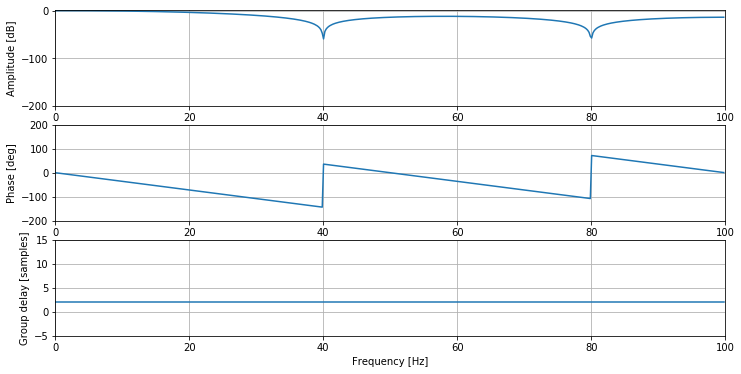

In [105]:
# グラフ表示
plt.figure(figsize=(12,6))
# 周波数特性
plt.subplot(3, 1, 1)
plt.plot(x_freq_rspns_ave, y_freq_rspns_ave)
plt.xlim(0, 100)
plt.ylim(-200, 2)  # MATLAB fvtool仕様
plt.ylabel('Amplitude [dB]')
plt.grid()

# 位相特性
plt.subplot(3, 1, 2)
plt.plot(x_freq_rspns_ave, p_ave)
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()

# 群遅延プロット
plt.subplot(3, 1, 3)
plt.plot(x_gd_ave, y_gd_ave)
plt.xlim(0, 100)
plt.ylim(-5, 15)  # MATLAB fvtool仕様
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group delay [samples]')
plt.grid()
plt.show()

##### フィルタ後の信号

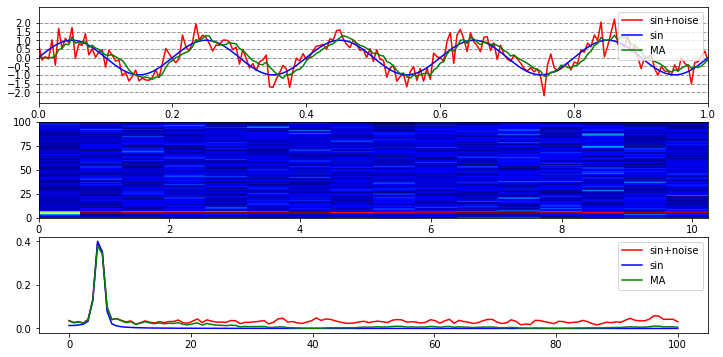

In [106]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x, c="red", label=("sin+noise"))
plt.plot(times, x_s, c="blue", label=("sin"))
plt.plot(times, moveave_x, c="green", label=("MA"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(x_np, dt)
plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 0
end = 2
f_raw, t_raw, Sxx_raw = dfilter.FFT(x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="red", label=("sin+noise"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(x_s, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("sin"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(moveave_x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="green", label=("MA"))
plt.legend()

# プロット表示(設定の反映)
plt.show()

 ### <span style="color: blue; ">Butterworthフィルタ</span>

In [4]:
dt = 0.005 #SamplingTime
fs = 1/dt  #周波数
ftype = 0 #lowpass=0, highpass=1, bandpass=2
fl = None #カットオフ周波数(遮断周波数) 低周波数側
fh = 20 #カットオフ周波数(遮断周波数) 高周波数側
order = 4 #次数

BFilter = dfilter.Butter_Filter()
ftype = BFilter.get_filtertype(ftype)
print(ftype)
y = BFilter.Butter_filter(x, dt, order, fl, fh, ftype)
x_freq_rspns_bu, y_freq_rspns_bu, p_bu, x_gd_bu, y_gd_bu = BFilter.character_Butter(dt, order, fl, fh, ftype)

Butterworse_Filter
lowpass
0.2 4


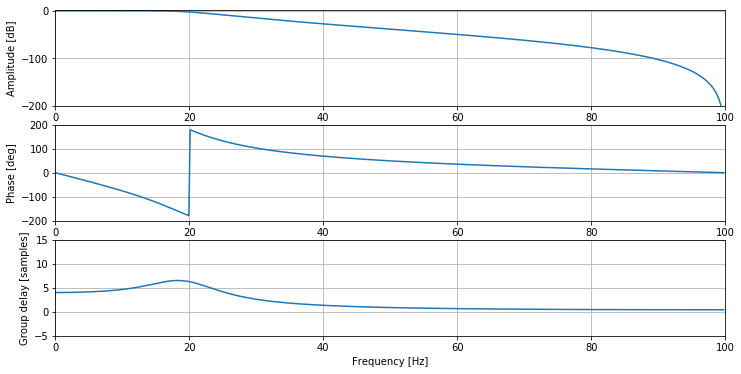

In [5]:
# グラフ表示
plt.figure(figsize=(12,6))
# 周波数特性
plt.subplot(3, 1, 1)
plt.plot(x_freq_rspns_bu, y_freq_rspns_bu)
plt.xlim(0, 100)
plt.ylim(-200, 2)  # MATLAB fvtool仕様
plt.ylabel('Amplitude [dB]')
plt.grid()

# 位相特性
plt.subplot(3, 1, 2)
plt.plot(x_freq_rspns_bu, p_bu)
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()

# 群遅延プロット
plt.subplot(3, 1, 3)
plt.plot(x_gd_bu, y_gd_bu)
plt.xlim(0, 100)
plt.ylim(-5, 15)  # MATLAB fvtool仕様
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group delay [samples]')
plt.grid()
plt.show()

##### フィルタ後の信号

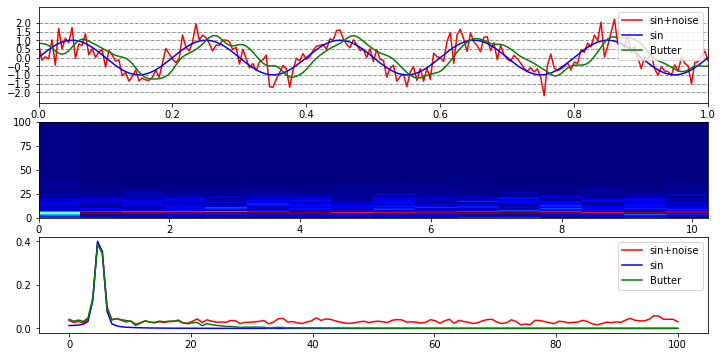

In [90]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x, c="red", label=("sin+noise"))
plt.plot(times, x_s, c="blue", label=("sin"))
plt.plot(times, y, c="green", label=("Butter"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 0
end = 2
f_raw, t_raw, Sxx_raw = dfilter.FFT(x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="red", label=("sin+noise"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(x_s, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("sin"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="green", label=("Butter"))
plt.legend()

# プロット表示(設定の反映)
plt.show()

### <span style="color: green; ">Chebyshev(first)フィルタ</span>

In [91]:
dt = 0.005 #SamplingTime
fs = 1/dt  #周波数
ftype = 0 #lowpass=0, highpass=1, bandpass=2
fl = None #カットオフ周波数(遮断周波数) 低周波数側
fh = 20 #カットオフ周波数(遮断周波数) 高周波数側
order = 4 #次数
attenuation = 5 #リップル(通過域最大損失量[dB])

CFilter = dfilter.Chebyshev_Filter()
ftype = CFilter.get_filtertype(ftype)
print(ftype)
y = CFilter.Chebyshev_filter(x, dt, order, fl, fh, attenuation, ftype)
x_freq_rspns_ch, y_freq_rspns_ch, p_ch, x_gd_ch, y_gd_ch = CFilter.character_Chebyshev(dt, order, fl, fh, ripple, ftype)

Chebyshev_Filter
lowpass


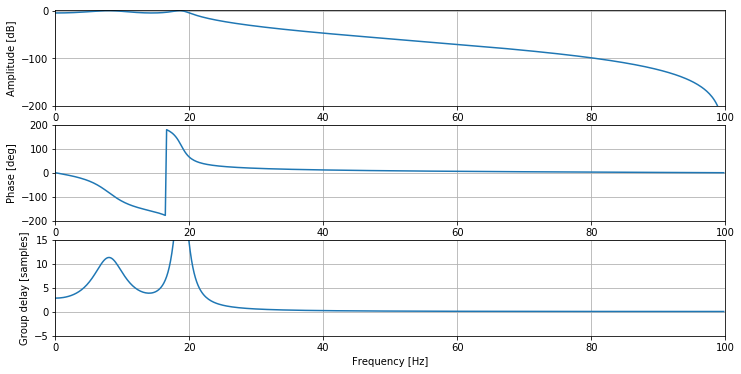

In [92]:
# グラフ表示
plt.figure(figsize=(12,6))
# 周波数特性
plt.subplot(3, 1, 1)
plt.plot(x_freq_rspns_ch, y_freq_rspns_ch)
plt.xlim(0, 100)
plt.ylim(-200, 2)  # MATLAB fvtool仕様
plt.ylabel('Amplitude [dB]')
plt.grid()

# 位相特性
plt.subplot(3, 1, 2)
plt.plot(x_freq_rspns_ch, p_ch)
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()

# 群遅延プロット
plt.subplot(3, 1, 3)
plt.plot(x_gd_ch, y_gd_ch)
plt.xlim(0, 100)
plt.ylim(-5, 15)  # MATLAB fvtool仕様
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group delay [samples]')
plt.grid()
plt.show()

##### フィルタ後の信号

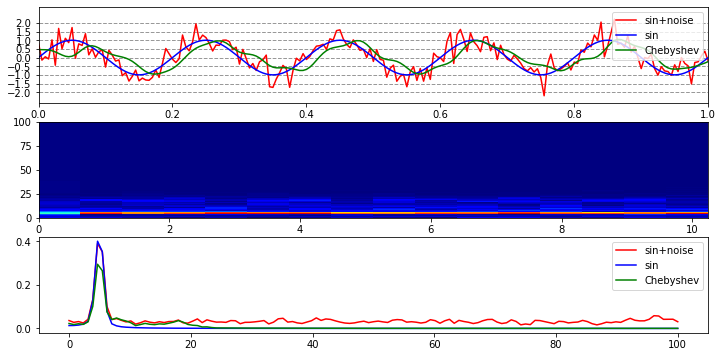

In [93]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x, c="red", label=("sin+noise"))
plt.plot(times, x_s, c="blue", label=("sin"))
plt.plot(times, y, c="green", label=("Chebyshev"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 0
end = 2
f_raw, t_raw, Sxx_raw = dfilter.FFT(x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="red", label=("sin+noise"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(x_s, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("sin"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="green", label=("Chebyshev"))
plt.legend()

# プロット表示(設定の反映)
plt.show()

### <span style="color: lightgreen; ">第二種Chebyshevフィルタ</span>

In [94]:
dt = 0.005 #SamplingTime
fs = 1/dt  #周波数
ftype = 0 #lowpass=0, highpass=1, bandpass=2
fl = None #カットオフ周波数(遮断周波数) 低周波数側
fh = 20 #カットオフ周波数(遮断周波数) 高周波数側
order = 4 #次数
attenuation = 10 #minimum attenuation(阻止域最小減衰量[dB])

CsFilter = dfilter.Chebyshev_second_Filter()
ftype = CsFilter.get_filtertype(ftype)
print(ftype)
y = CsFilter.Chebyshev_second_filter(x+1, dt, order, fl, fh, attenuation, ftype)
x_freq_rspns_ch2, y_freq_rspns_ch2, p_ch2, x_gd_ch2, y_gd_ch2 = CsFilter.character_Chebyshev_second(dt, order, fl, fh, attenuation, ftype)

Chebyshev_Filter
lowpass


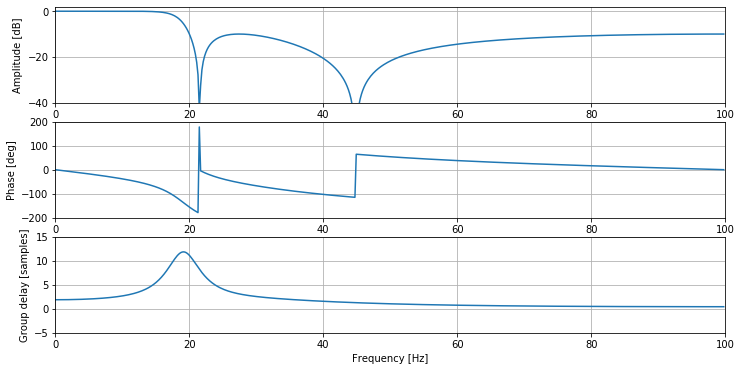

In [95]:
# グラフ表示
plt.figure(figsize=(12,6))
# 周波数特性
plt.subplot(3, 1, 1)
plt.plot(x_freq_rspns_ch2, y_freq_rspns_ch2)
plt.xlim(0, 100)
plt.ylim(-40, 2)  # MATLAB fvtool仕様
plt.ylabel('Amplitude [dB]')
plt.grid()

# 位相特性
plt.subplot(3, 1, 2)
plt.plot(x_freq_rspns_ch2, p_ch2)
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()

# 群遅延プロット
plt.subplot(3, 1, 3)
plt.plot(x_gd_ch2, y_gd_ch2)
plt.xlim(0, 100)
plt.ylim(-5, 15)  # MATLAB fvtool仕様
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group delay [samples]')
plt.grid()
plt.show()

##### フィルタ後の信号

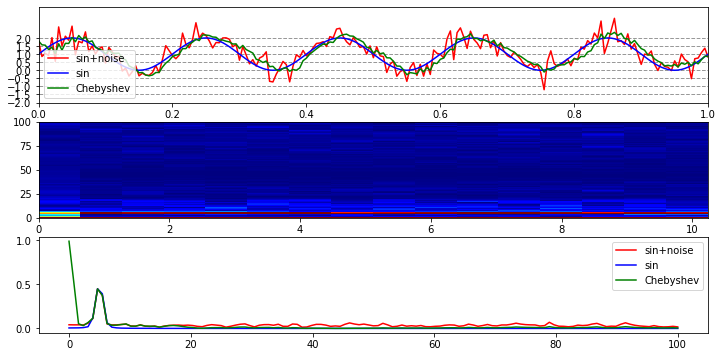

In [96]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x+1, c="red", label=("sin+noise"))
plt.plot(times, x_s+1, c="blue", label=("sin"))
plt.plot(times, y, c="green", label=("Chebyshev"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 8
end = 10
f_raw, t_raw, Sxx_raw = dfilter.FFT(x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="red", label=("sin+noise"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(x_s, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("sin"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="green", label=("Chebyshev"))
plt.legend()

# プロット表示(設定の反映)
plt.show()

### <span style="color: orange; ">Besselフィルタ</span>

In [6]:
dt = 0.005 #SamplingTime
fs = 1/dt  #周波数
ftype = 0 #lowpass=0, highpass=1, bandpass=2
fl = None #カットオフ周波数(遮断周波数) 低周波数側
fh = 20 #カットオフ周波数(遮断周波数) 高周波数側
order = 4 #次数

BeFilter = dfilter.Bessel_Filter()
ftype = BeFilter.get_filtertype(ftype)
print(ftype)
y = BeFilter.Bessel_filter(x, dt, order, fl, fh, ftype)
x_freq_rspns_be, y_freq_rspns_be, p_be, x_gd_be, y_gd_be = BeFilter.character_Bessel(dt, order, fl, fh, ftype)

Chebyshev_Filter
lowpass


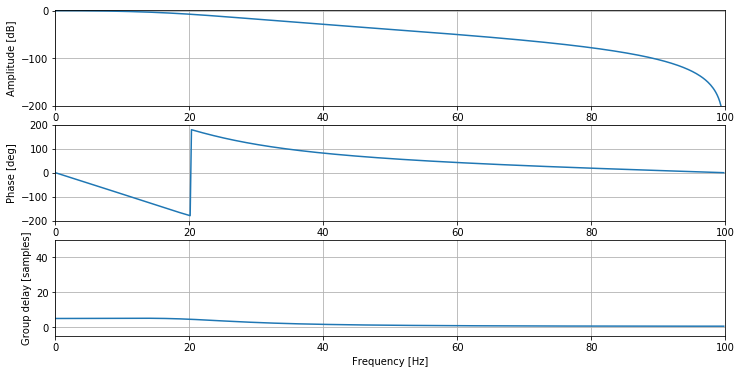

In [7]:
# グラフ表示
plt.figure(figsize=(12,6))
# 周波数特性
plt.subplot(3, 1, 1)
plt.plot(x_freq_rspns_be, y_freq_rspns_be)
plt.xlim(0, 100)
plt.ylim(-200, 2)  # MATLAB fvtool仕様
plt.ylabel('Amplitude [dB]')
plt.grid()

# 位相特性
plt.subplot(3, 1, 2)
plt.plot(x_freq_rspns_be, p_be)
plt.xlim(0, 100)
plt.ylim(-200, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
plt.grid()

# 群遅延プロット
plt.subplot(3, 1, 3)
plt.plot(x_gd_be, y_gd_be)
plt.xlim(0, 100)
plt.ylim(-5, 50)  # MATLAB fvtool仕様
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group delay [samples]')
plt.grid()
plt.show()

##### フィルタ後の信号

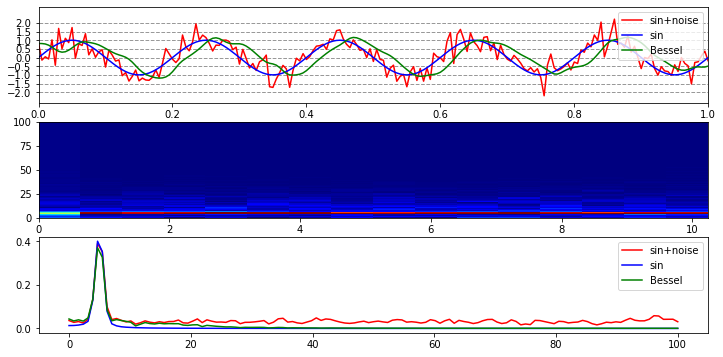

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(times, x, c="red", label=("sin+noise"))
plt.plot(times, x_s, c="blue", label=("sin"))
plt.plot(times, y, c="green", label=("Bessel"))

#軸調整
plt.xlim(0,1)
plt.yticks([-2, -1.5, -1, -0.5, 0, 0.5,1, 1.5, 2])
plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
        linestyle = "--", linewidth = 1)
plt.legend()

f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
plt.subplot(3,1,2)
plt.pcolormesh(t_raw, f_raw, np.abs(Sxx_raw),vmin=0, vmax=0.4, cmap="jet")

plt.subplot(3,1,3)
start = 0
end = 2
f_raw, t_raw, Sxx_raw = dfilter.FFT(x, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="red", label=("sin+noise"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(x_s, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="blue", label=("sin"))
f_raw, t_raw, Sxx_raw = dfilter.FFT(y, dt)
gain = dfilter.ave_spectrum(np.abs(Sxx_raw), t_raw, start, end)
plt.plot(f_raw, gain, c="green", label=("Bessel"))
plt.legend()

# プロット表示(設定の反映)
plt.show()